In [222]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

In [223]:
torch.manual_seed(42)
DATA_PATH = './data'

CHANNELS = 1

BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 0.0001

Z_DIM = 10
NUM_CLASSES = 10
LABEL_EMBED_SIZE = 5

IMAGES_DISPLAY_PER_CLASS = 20

LABEL_DICT = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker',
                8: 'Bag', 9: 'Ankle boot'}

In [224]:
def generate_image(generator, label, model):
    generator.eval()
    z = torch.randn(1, Z_DIM)
    if torch.cuda.is_available():
        generator = generator.cuda()
        z = z.cuda()

    # for 30 time steps
    for i in range(6):
        x = generator(z, label)
        if torch.cuda.is_available():
            x = x.cpu()
        x = x.view(32, 32).detach().numpy()
        plt.subplot(1, 6, i+1)
        plt.imshow(x, cmap='gray')
        plt.axis('off')
        z = torch.randn(1, Z_DIM).cuda(
        ) if torch.cuda.is_available() else torch.randn(1, Z_DIM)
        if (i+1) == 2:
            name = "Model:" + model + "   " + "Label:" + \
                str(label.item()) + "-" + LABEL_DICT[label.item()]
            fontdict = {'fontsize': 15, 'fontweight': 'medium', }
            plt.title(label=name, fontdict=fontdict, loc='left')
        if (i+1) == 6:
            plt.show()


In [225]:
#######################################################################
# conv_block: Convolutional block used in the generator and discriminator
#######################################################################

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, transpose=False):
    layers = []
    if transpose:
        conv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv_layer)
    else:
        conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [226]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, n_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(n_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, padding=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, batch_norm=False, transpose=True)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1.0)
                nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embed(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat([x, label_embed], dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x

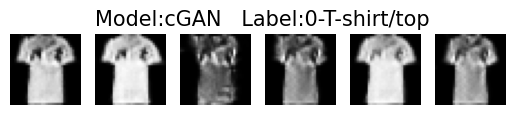

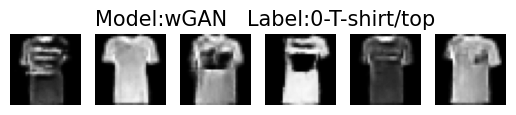

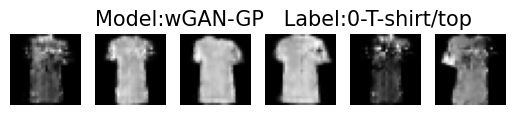

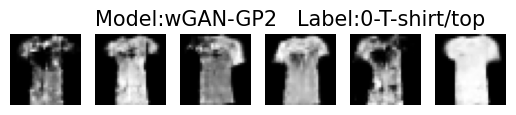

In [227]:
def generator():
    # input the label and model
    model = str(input('Enter a model index (1: cGAN, 2: wGAN, 3: wGAN-GP, 4: wGAN-GP2, 5: all): '))
    label = str(input('Enter a label index or name(0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot): '))
    # label = "8"
    model_dict = {'1': 'cGAN', '2': 'wGAN', '3': 'wGAN-GP', '4': 'wGAN-GP2', '5': 'all'}

    # let label first char to be upper case
    label = label[0].upper() + label[1:].lower()

    # find the label form dictionary
    for key, value in LABEL_DICT.items():
        if value == label:
            label = key
        if label == key:
            break
    # check if the label is valid
    try:
        label = int(label)
        if label < 0 or label > 9:
            raise Exception
    except:
        print('Label not found')
        return

    label = torch.tensor([label]).cuda(
    ) if torch.cuda.is_available() else torch.tensor([label])
    if model not in model_dict.keys():
        print('Model not found')
        return
    model = model_dict[model]
    # generate image
    if model == 'all':
        for i in range(0, 4):
            model = model_dict[str(i+1)]
            if model == 'wGAN-GP2':
                MODEL_PATH = './model/'+model_dict['3']+'/' + 'generator2.pth'
                generator = Generator(Z_DIM, NUM_CLASSES, LABEL_EMBED_SIZE, CHANNELS)
                generator.load_state_dict(torch.load(MODEL_PATH))
                generate_image(generator, label, model)
            else:
                MODEL_PATH = './model/'+model+'/' + 'generator.pth'
                generator = Generator(Z_DIM, NUM_CLASSES, LABEL_EMBED_SIZE, CHANNELS)
                generator.load_state_dict(torch.load(MODEL_PATH))
                generate_image(generator, label, model)
    elif model == 'wGAN-GP2':
        MODEL_PATH = './model/'+model_dict['3']+'/' + 'generator2.pth'
        generator = Generator(Z_DIM, NUM_CLASSES, LABEL_EMBED_SIZE, CHANNELS)
        generator.load_state_dict(torch.load(MODEL_PATH))
        generate_image(generator, label, model)
    else:
        MODEL_PATH = './model/'+model+'/' + 'generator.pth'
        generator = Generator(Z_DIM, NUM_CLASSES, LABEL_EMBED_SIZE, CHANNELS)
        generator.load_state_dict(torch.load(MODEL_PATH))
        generate_image(generator, label, model)

generator()